In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from keras import backend as K

from Unet import SwinUNet, ConvNeXTUNet
from dataset_gen import DataGenerator

In [4]:
train_data = DataGenerator('/content/drive/MyDrive/image_segmentation_data/data/train', batch_size = 32)
val_data = DataGenerator('/content/drive/MyDrive/image_segmentation_data/data/val', batch_size = 32, predicting = True)

In [5]:
@tf.keras.saving.register_keras_serializable()
def dice_coef(y_true, y_pred):
  y_pred = tf.nn.softmax(y_pred)
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (2. * intersection + 0.01) / (K.sum(y_true_f) + K.sum(y_pred_f) + 0.01)

@tf.keras.saving.register_keras_serializable()
def dice_coef_multilabel(y_true, y_pred, numLabels=35):
    dice=0
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index])
    return dice

In [6]:
swin_model = SwinUNet(128, 35, window_size = 4, patch_size=4, embed_dim = 96, depths = [2, 2, 2, 2], num_heads = [3, 3, 6, 6], attn_drop_rate = 0.3, proj_drop_rate = 0.3)
swin_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0001, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [7]:
swin_history = swin_model.fit(train_data, epochs = 30, validation_data = val_data)

Epoch 1/30
94/94 [==============================] - 192s 2s/step - loss: 0.4522 - accuracy: 0.5127 - dice_coef_multilabel: 0.2562 - val_loss: 0.3961 - val_accuracy: 0.5829 - val_dice_coef_multilabel: 0.2654
Epoch 2/30
94/94 [==============================] - 138s 1s/step - loss: 0.3117 - accuracy: 0.6992 - dice_coef_multilabel: 0.3090 - val_loss: 0.3304 - val_accuracy: 0.6692 - val_dice_coef_multilabel: 0.3131
Epoch 3/30
94/94 [==============================] - 143s 2s/step - loss: 0.2925 - accuracy: 0.7314 - dice_coef_multilabel: 0.3430 - val_loss: 0.3021 - val_accuracy: 0.7156 - val_dice_coef_multilabel: 0.3369
Epoch 4/30
94/94 [==============================] - 137s 1s/step - loss: 0.2832 - accuracy: 0.7449 - dice_coef_multilabel: 0.3606 - val_loss: 0.2858 - val_accuracy: 0.7437 - val_dice_coef_multilabel: 0.3586
Epoch 5/30
94/94 [==============================] - 147s 2s/step - loss: 0.2762 - accuracy: 0.7556 - dice_coef_multilabel: 0.3756 - val_loss: 0.2848 - val_accuracy: 0.7420 

In [8]:
os.makedirs('/content/drive/MyDrive/SaveModels', exist_ok=True)
swin_model.save('/content/drive/MyDrive/SaveModels/swinmodel.keras', save_format="keras")

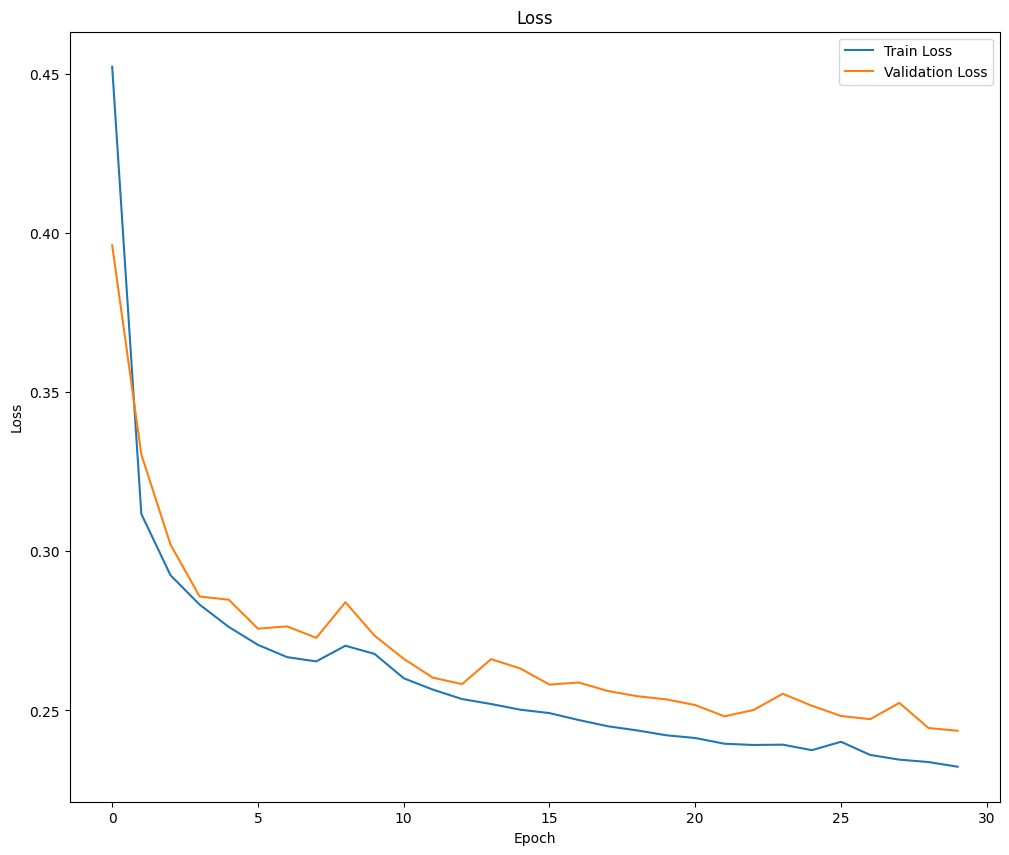

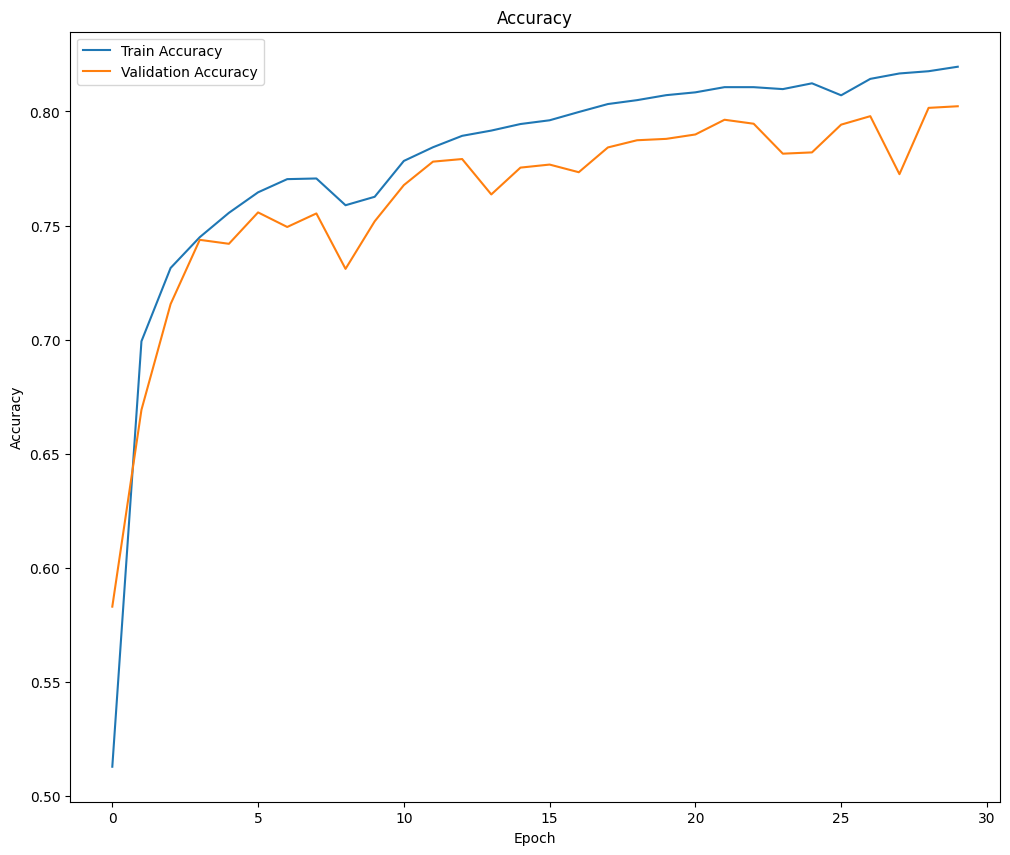

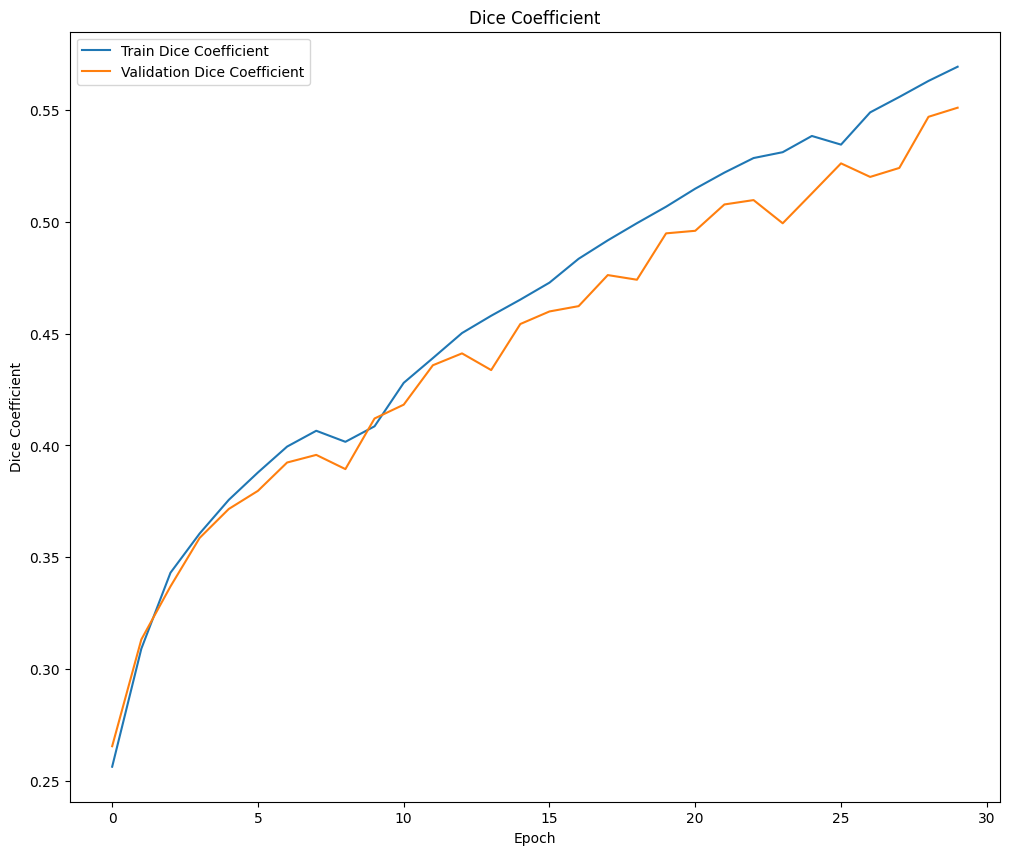

In [9]:
os.makedirs('/content/drive/MyDrive/save_plots/swinmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['loss'], label='Train Loss')
plt.plot(swin_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/swinmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['accuracy'], label='Train Accuracy')
plt.plot(swin_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/swinmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(swin_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(swin_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/swinmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [10]:
conv_model = ConvNeXTUNet(128, 96, 35, [2, 2, 2, 2])
conv_model.compile(
    optimizer=tf.keras.optimizers.AdamW(weight_decay = 0.0001, learning_rate = 0.001),
    loss = tf.keras.losses.CategoricalFocalCrossentropy(label_smoothing = 0.1, from_logits = True),
    metrics= ['accuracy', dice_coef_multilabel],
)

In [11]:
conv_history = conv_model.fit(train_data, epochs = 30, validation_data = val_data)

Epoch 1/30
94/94 [==============================] - 170s 1s/step - loss: 0.4405 - accuracy: 0.5359 - dice_coef_multilabel: 0.2650 - val_loss: 0.3897 - val_accuracy: 0.5620 - val_dice_coef_multilabel: 0.2532
Epoch 2/30
94/94 [==============================] - 136s 1s/step - loss: 0.3048 - accuracy: 0.7093 - dice_coef_multilabel: 0.3045 - val_loss: 0.3330 - val_accuracy: 0.6844 - val_dice_coef_multilabel: 0.2885
Epoch 3/30
94/94 [==============================] - 139s 1s/step - loss: 0.2892 - accuracy: 0.7317 - dice_coef_multilabel: 0.3299 - val_loss: 0.3021 - val_accuracy: 0.7171 - val_dice_coef_multilabel: 0.3071
Epoch 4/30
94/94 [==============================] - 143s 2s/step - loss: 0.2790 - accuracy: 0.7485 - dice_coef_multilabel: 0.3510 - val_loss: 0.2893 - val_accuracy: 0.7308 - val_dice_coef_multilabel: 0.3462
Epoch 5/30
94/94 [==============================] - 143s 2s/step - loss: 0.2717 - accuracy: 0.7599 - dice_coef_multilabel: 0.3711 - val_loss: 0.2867 - val_accuracy: 0.7411 

In [12]:
conv_model.save('/content/drive/MyDrive/SaveModels/conv_nextmodel.keras', save_format="keras")

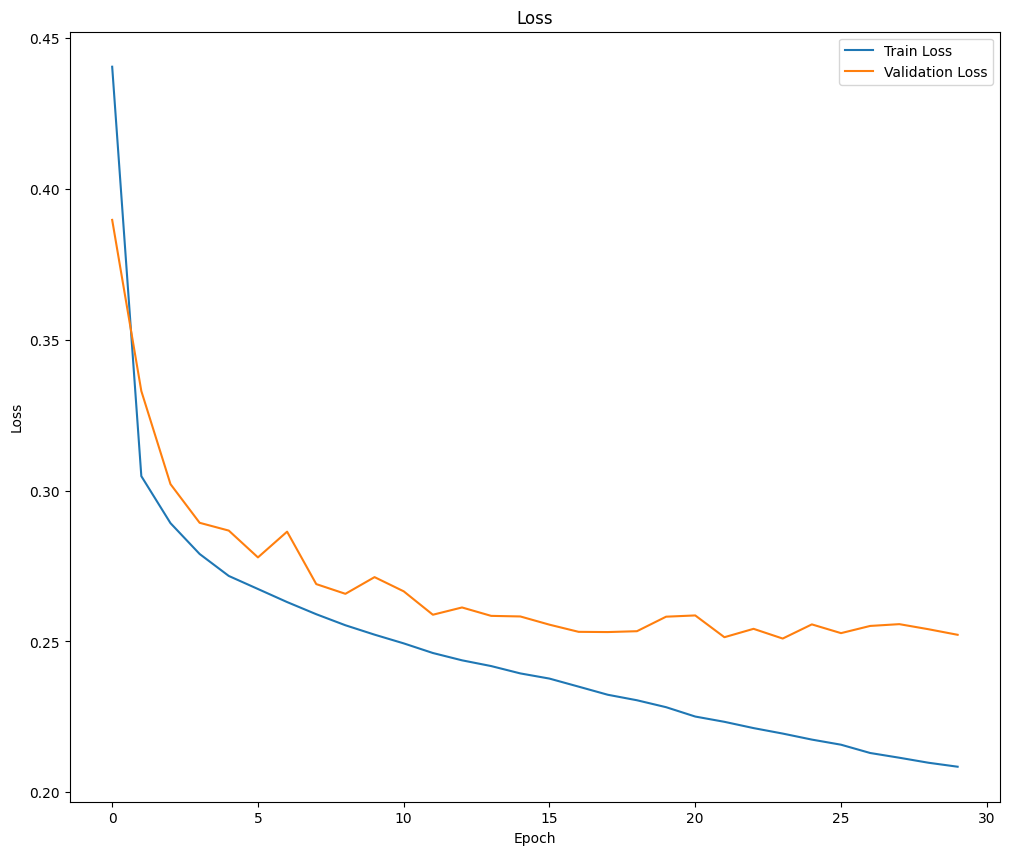

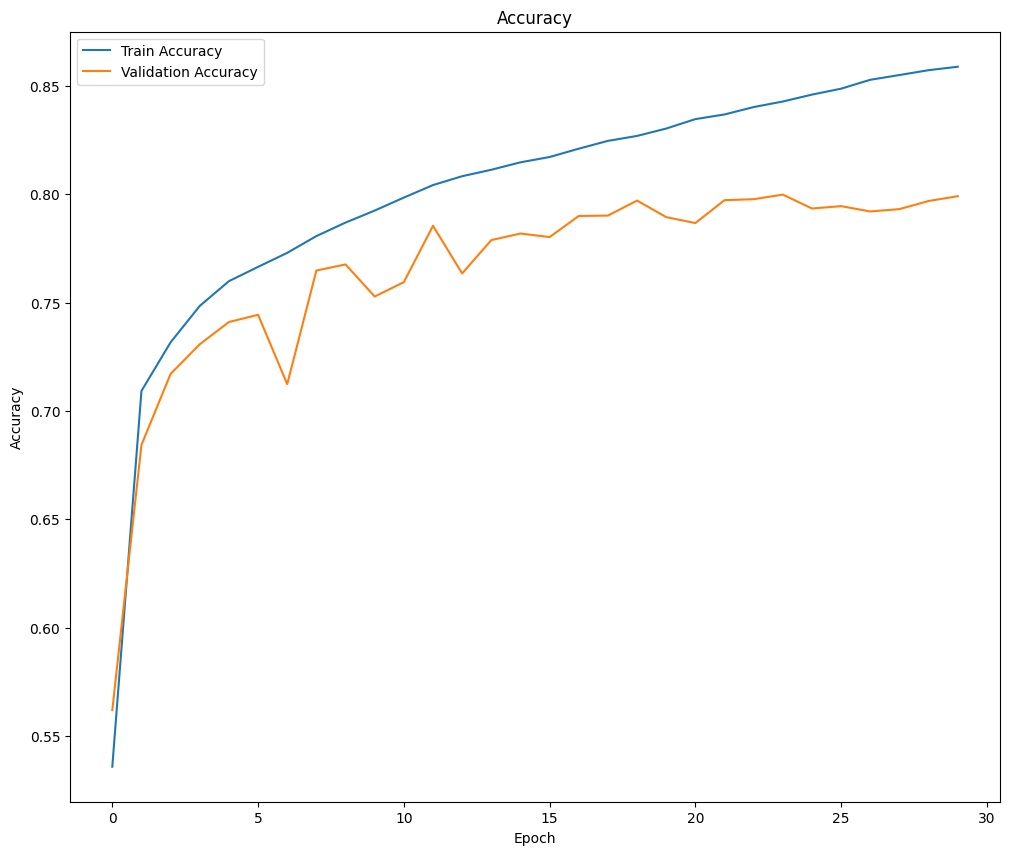

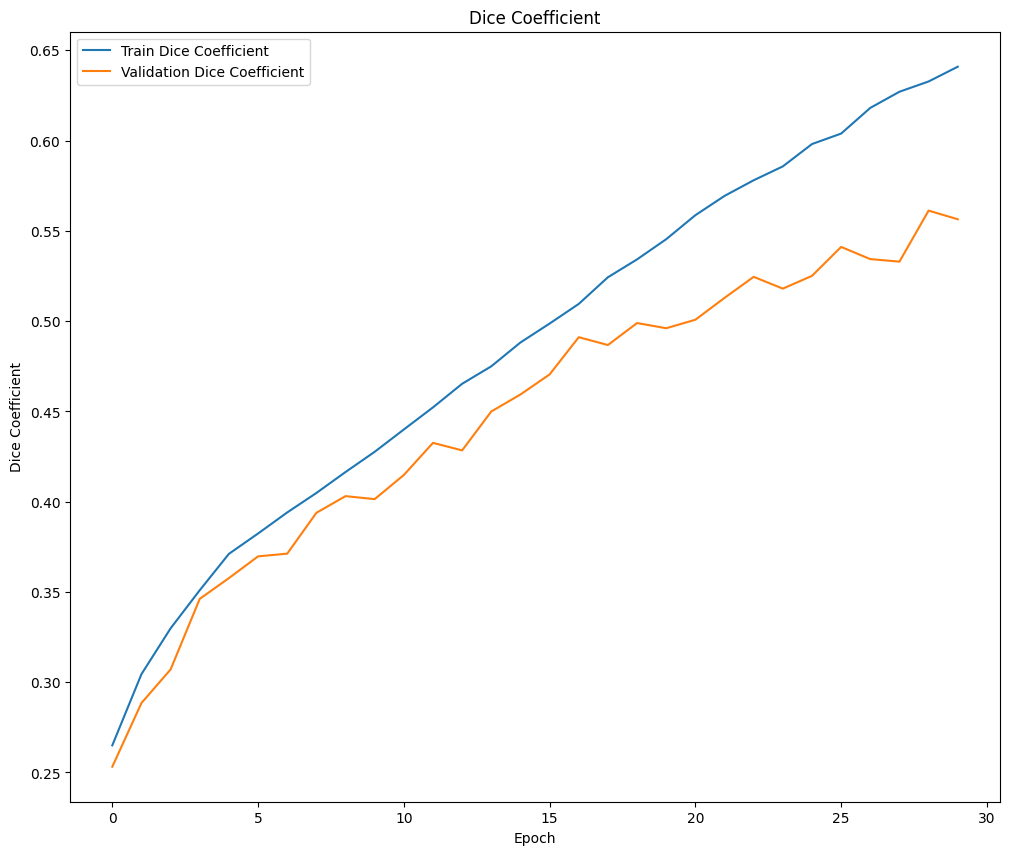

In [13]:
os.makedirs('/content/drive/MyDrive/save_plots/convmodel', exist_ok=True)

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['loss'], label='Train Loss')
plt.plot(conv_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/convmodel/lossplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['accuracy'], label='Train Accuracy')
plt.plot(conv_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/convmodel/accuracyplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

plt.figure(figsize=(12, 10))
plt.plot(conv_history.history['dice_coef_multilabel'], label='Train Dice Coefficient')
plt.plot(conv_history.history['val_dice_coef_multilabel'], label='Validation Dice Coefficient')
plt.title('Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend()
plt.savefig('/content/drive/MyDrive/save_plots/convmodel/diceplot.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close()


In [14]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = swin_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 4s 4s/step


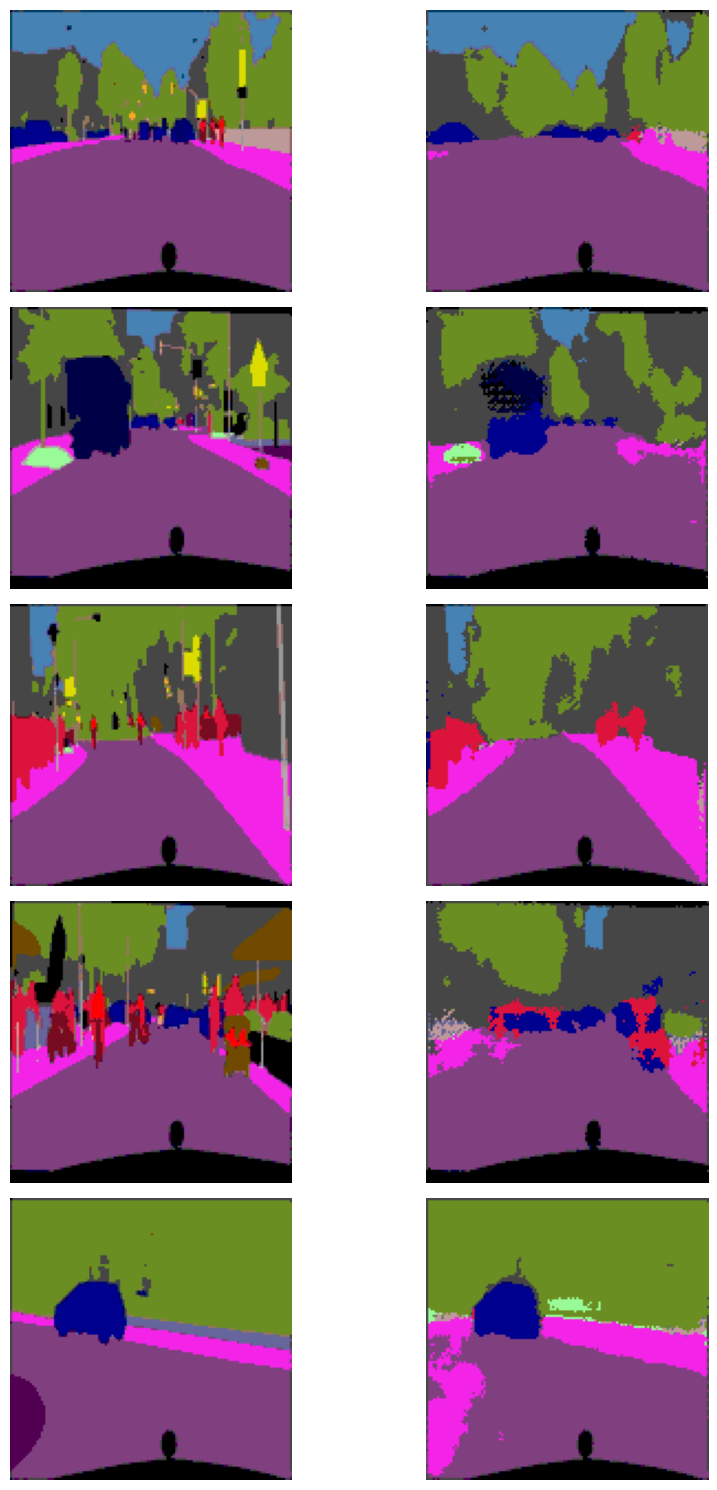

In [15]:
from labeldata import id_to_color
from PIL import Image

fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()



In [16]:
for img, mask in val_data:
  true_mask = mask[:5]
  imgs = img[:5]
  break

prediction = conv_model.predict(tf.reshape(imgs, [5, 128, 128, 3]))
true_masks = np.argmax(true_mask, axis = -1)
predictions = np.argmax(prediction, axis = -1)

1/1 [==============================] - 2s 2s/step


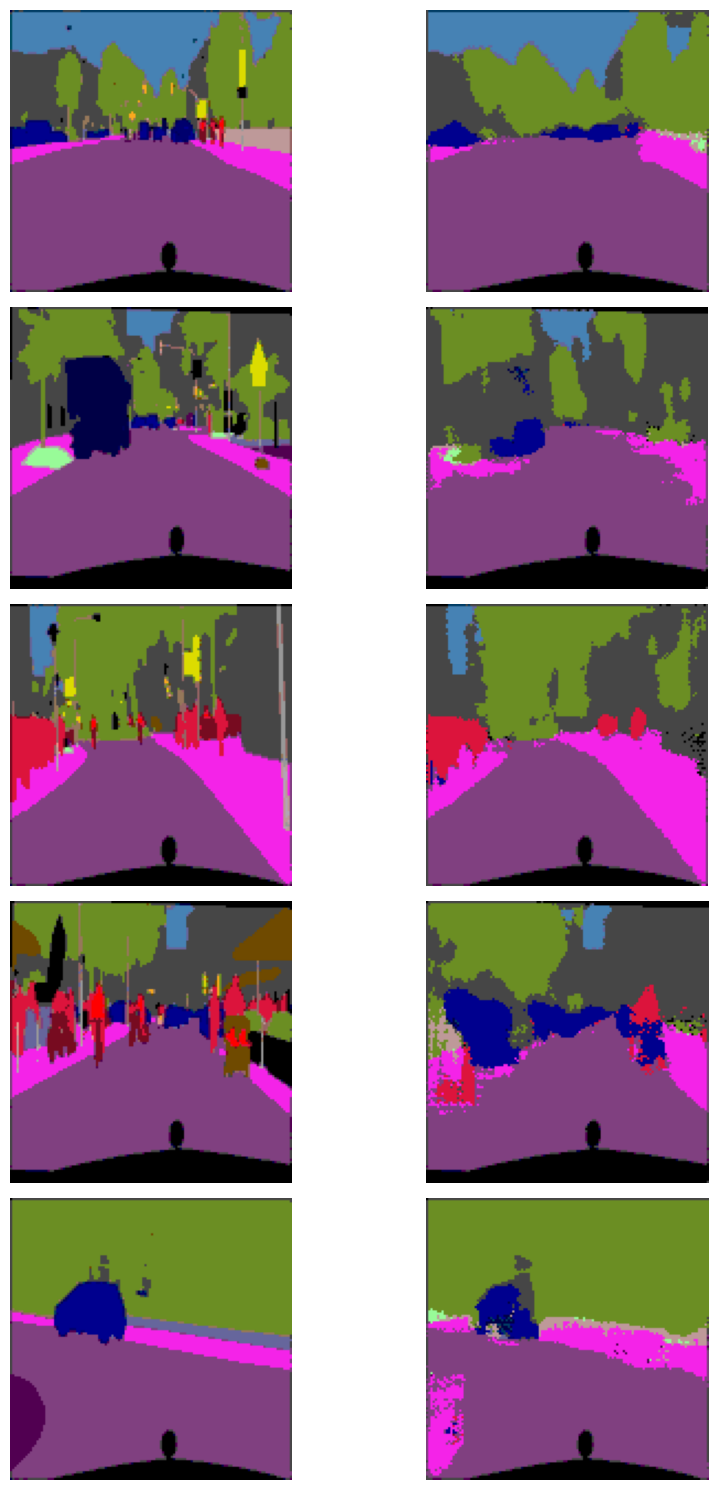

In [17]:
fig, axes = plt.subplots(5, 2, figsize=(10, 15))

for index, (true_mask, prediction) in enumerate(zip(true_masks, predictions)):

    # Display the true mask
    temp = np.zeros([true_mask.shape[0], true_mask.shape[0], 3], dtype='uint8')
    for row in range(true_mask.shape[0]):
        for col in range(true_mask.shape[0]):
            temp[row, col, :] = id_to_color[true_mask[row, col]]

    axes[index, 0].imshow(temp)
    axes[index, 0].axis('off')
    # Display the corresponding prediction
    temp = np.zeros([prediction.shape[0], prediction.shape[0], 3], dtype='uint8')
    for row in range(prediction.shape[0]):
        for col in range(prediction.shape[0]):
            temp[row, col, :] = id_to_color[prediction[row, col]]

    axes[index, 1].imshow(temp)
    axes[index, 1].axis('off')

plt.tight_layout()
plt.show()

